### Sub-class Scoring

In [1]:
from utils.all import *
from scipy.stats import kendalltau, pearsonr, spearmanr

data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_anton.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_ayush.json', '../annotated/batch_9_kelly.json', '../annotated/batch_9_rachel.json', '../annotated/

In [2]:
# Add pre-computed scores
with open('comet/computed-scores.json', 'r') as f:
    scores = json.load(f)
scores = [s for s in scores if 'bleu' in s.keys()]

In [3]:
# Add LENS scores
# path = 'comet/lens-simpeval-22.csv'
path = 'comet/simpeval_2022_wrescaledlens.csv'
with open(path, encoding='utf-8') as f:
    reader = csv.reader(f)
    keys = next(reader)
    contents = [row for row in reader]
    lens = []
    for sent in contents:
        lens += [{k: v for k, v in zip(keys, sent)}]

for score in scores:
    # Ensure both the system and sentence is the same
    aligned = [sent for sent in lens if 
        sent['original'] == score['original'] and
        sent['system'] in score['system']
    ]

    if len(aligned) == 0 or 'LENS' not in aligned[0].keys():
        score['lens'] = 0
        continue

    lens_score = float(aligned[0]['LENS'])
    score['lens'] = lens_score

In [4]:
# NEED TO REDO THE BELOW - Should have ~818 scores
len(scores)

806

In [5]:
# Add our scores
conditions = [
    'quality_content', 
    'quality_syntax', 
    'quality_lexical', 
    'error_content', 
    'error_syntax', 
    'error_lexical', 
    'quality', 
    'error', 
    'all'
]

# Create a scores list with references and simplifications
our_scores = []
for orig in set([x['original'] for x in data]):
    sents = [sent for sent in data if sent['original'] == orig]

    human = [sent for sent in sents if 'Human' in sent['system']]
    systems = [sent for sent in sents if 'Human' not in sent['system']] # Or you can try just GPT-3-Few

    if len(systems) == 0:
        continue

    for system in systems:
        # print(system['system'])
        # print(score['system'])
        aligned = [sent for sent in scores if 
            sent['original'] == orig and
            sent['system'] in system['system'] 
        ]

        if len(aligned) == 0:
            continue
            
        n_score = aligned[0]
        
        n_score['our_score'] = system['score']
        for condition in conditions:
            n_score[f'our_score_{condition}'] = calculate_sentence_score(system, get_params(condition))
            if 'error' in condition:
                n_score[f'our_score_{condition}'] = -n_score[f'our_score_{condition}']

        our_scores += [n_score]

print(f"Calculating sensitivity with scores for {len(scores)} sentences")

Calculating sensitivity with scores for 806 sentences


### Metric Sensitivity

In [6]:
scores = our_scores
scores = [s for s in scores if 'comet' in s.keys()]

In [7]:
condition_name_mapping = {
    'quality_lexical': 'Lexical',
    'quality_syntax': 'Syntax',
    'quality_content': 'Conceptual',
    'error_lexical': 'Lexical',
    'error_syntax': 'Syntax',
    'error_content': 'Conceptual',
    'error': 'All Error',
    'quality': 'All Quality',
    'all': 'All Edits'
}

In [8]:
# Calculate Kendall Tau correlation for each statistic
import heapq
metrics = ['bleu', 'sari', 'bertscore', 'comet', 'lens']
all_results = []
prec = 3

# Calculate metric corrleation
for metric in metrics:
    sys_results = []
    for condition in condition_name_mapping.keys():
        p = pearsonr([s[f'our_score_{condition}'] for s in scores], [s[metric] for s in scores])
        sp = spearmanr([s[f'our_score_{condition}'] for s in scores], [s[metric] for s in scores])
        results = (round(sp[0], prec), round(p[0], prec))
        sys_results += [results]
    all_results += [sys_results]

# Render LaTeX table
delimiters = [
    '\multirow{3}{*}{\\rotatebox[origin=c]{90}{Quality}}',
    '\multirow{3}{*}{\\rotatebox[origin=c]{90}{Error}}',
    '\multirow{3}{*}{\\rotatebox[origin=c]{90}{All}}'
]

out = ''
for i, condition in enumerate(condition_name_mapping.keys()):
    line = ''

    if i % 3 == 0:
        if i != 0:
            line += '\\midrule\n'
        line += f'{delimiters[int(i/3)]} '
        
    line += f'& {condition_name_mapping[condition]} & '
    a_max_p, b_max_p = heapq.nlargest(2, [x[i][0] for x in all_results])
    a_max_sp, b_max_sp = heapq.nlargest(2, [x[i][1] for x in all_results])
    for j, metric in enumerate(metrics):
        p = all_results[j][i][0]
        sp = all_results[j][i][1]

        if str(p) == 'nan':
            p = '---'
        if str(sp) == 'nan':
            sp = '---'

        if p == a_max_p:
            p = f'\\textbf{{{round(p, prec):.3f}}}'
        elif sp == a_max_sp:
            sp = f'\\textbf{{{round(sp, prec):.3f}}}'
        elif p == b_max_p:
            p = f'\\underline{{{round(p, prec):.3f}}}'
        elif sp == b_max_sp:
            sp = f'\\underline{{{round(sp, prec):.3f}}}'
        else:
            p = f'{round(p, prec):.3f}'

        # line += f'{p} & {sp} & '
        line += f'{p} & '
    out += line[:-2] + '\\tabularnewline\n'
print(out)

\multirow{3}{*}{\rotatebox[origin=c]{90}{Quality}} & Lexical & -0.289 & -0.040 & -0.096 & \underline{0.061} & \textbf{0.446} \tabularnewline
& Syntax & -0.247 & \underline{0.063} & -0.063 & -0.084 & \textbf{0.434} \tabularnewline
& Conceptual & -0.183 & 0.020 & -0.117 & \underline{0.091} & \textbf{0.217} \tabularnewline
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{Error}} & Lexical & -0.300 & -0.189 & -0.109 & 0.042 & \textbf{0.055} \tabularnewline
& Syntax & -0.169 & -0.112 & -0.104 & \underline{-0.035} & \textbf{0.053} \tabularnewline
& Conceptual & -0.142 & -0.139 & -0.250 & \underline{-0.126} & \textbf{0.137} \tabularnewline
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{All}} & All Error & -0.310 & -0.228 & -0.334 & \underline{-0.119} & \textbf{0.180} \tabularnewline
& All Quality & -0.351 & -0.020 & -0.189 & \underline{0.060} & \textbf{0.475} \tabularnewline
& All Edits & -0.247 & 0.034 & -0.070 & \underline{0.083} & \textbf{0.397} \tabularnewline



In [9]:
break

SyntaxError: 'break' outside loop (<ipython-input-9-6aaf1f276005>, line 1)

### Correlation between Qualtiy and Error

In [ ]:
from utils.all import *

data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9, 10, 11], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_kelly.json']

Found users: {'anton', 'rachel', 'ayush', 'vishnesh', 'kelly', 'vinayak'}

anton - Batch 5, HIT 38 (ID 37) has 2 deleti

In [ ]:
# Calculate the each score for all unique sentences
# For each sentence, we have 5 generations and 3 annotations per generation
# Of the 5 generations, 2 are ASSET human references, 1 is TurkCorpus human reference

plt.rcParams["figure.figsize"] = [5, 4]

conditions = [
    'quality_content', 
    'quality_syntax', 
    'quality_lexical', 
    'error_content', 
    'error_syntax', 
    'error_lexical', 
    'quality', 
    'error', 
    'all'
]

scores = []
for sent in data:
    our_score = sent['score']

    score = {
        'original': sent['original'],
        'simplified': sent['simplified'],
        'errors': list(set([ann['error_type'] for ann in sent['processed_annotations'] if ann['error_type'] != None])),
        'our_score': our_score
    }

    # The next goal is to calculate a bunch of variations on our score considering only
    # certain dimensions of the metric
    for condition in conditions:
        score[f'our_score_{condition}'] = calculate_sentence_score(sent, get_params(condition))

    scores += [score]

50.61% of sentences are error-less


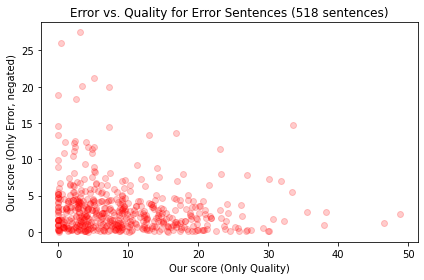

In [ ]:
pts = [(score['our_score_quality'], -score['our_score_error']) for score in scores]
print(f'{(100*sum([x[1] == 0 for x in pts]) / len(pts)):.2f}% of sentences are error-less')
pts = [x for x in pts if x[1] > 0]

plt.scatter([p[0] for p in pts], [p[1] for p in pts], c ="red", alpha=0.2)
plt.xlabel('Our score (Only Quality)')
plt.ylabel('Our score (Only Error, negated)')
plt.title(f'Error vs. Quality for Error Sentences ({len(pts)} sentences)')
out_filename = f'img/error-vs-quality.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

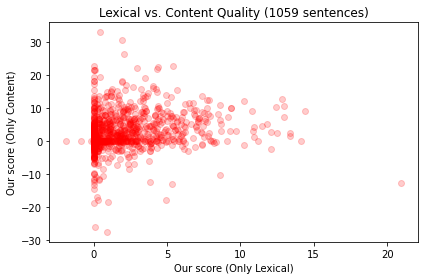

In [ ]:
pts = [(score['our_score_quality_lexical'], score['our_score_quality_content']) for score in scores]
plt.scatter([p[0] for p in pts], [p[1] for p in pts], c ="red", alpha=0.2)
plt.xlabel('Our score (Only Lexical)')
plt.ylabel('Our score (Only Content)')
plt.title(f'Lexical vs. Content Quality ({len(pts)} sentences)')
plt.show()

### Components of Simplification

In [ ]:
# graph simplicity/adequacy/fluency vs simpeval score
# graph content/syntax/grammar vs simpeval score
# graph content vs syntax, syntax vs grammar, grammar vs content

In [ ]:
data = load_data('../annotated', batch_num=[5, 6], preprocess=True) # [1, 2, 3, 4]
systems = set([x['system'] for x in data])

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'kelly', 'vishnesh', 'vinayak', 'ayush', 'rachel', 'anton'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

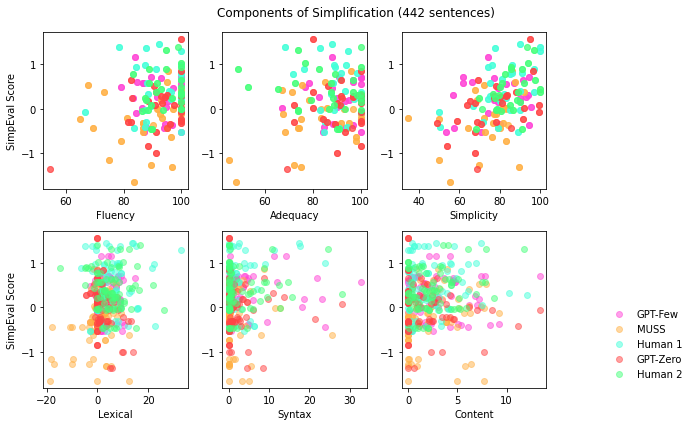

In [ ]:
conditions = [
    'quality_content', 
    'quality_syntax', 
    'quality_lexical', 
    'error_content', 
    'error_syntax', 
    'error_lexical', 
    'quality', 
    'error', 
    'all'
]

total_sent = 0
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
for system in systems:    
    fluency, adequacy, simplicity = [], [], []
    our_score = []
    for sent in [s for s in data if s['system'] == system]:
        if sent['simpeval_scores'] != None and sent['da_scores'] != None:
            # edit distance
            # scores += [(
            #     avg(sent['simpeval_scores'], prec=10), 
            #     edit_dist(sent['original'], sent['simplified'])
            # )]
            score = {}
            for condition in conditions:
                score[f'our_score_{condition}'] = calculate_sentence_score(sent, get_params(condition))
            
            fluency += [(
                avg([x['fluency'] for x in sent['da_scores']]),
                avg(sent['simpeval_scores'], prec=10)
            )]
            adequacy += [(
                avg([x['adequacy'] for x in sent['da_scores']]),
                avg(sent['simpeval_scores'], prec=10)
            )]
            simplicity += [(
                avg([x['simplicity'] for x in sent['da_scores']]),
                avg(sent['simpeval_scores'], prec=10)
            )]

            out_score = []
            for condition in ['quality_content', 'quality_syntax', 'quality_lexical']:
                out_score += [(
                    score[f'our_score_{condition}'],
                    avg(sent['simpeval_scores'], prec=10)
                )]
            our_score += [out_score]
                

        total_sent += 1
    # scores = [(sent['score'], edit_dist(sent['original'], sent['simplified'])) for sent in data if sent['system'] == system]

    axs[0, 0].scatter([p[0] for p in fluency], [p[1] for p in fluency], c=color_mapping[system], alpha=0.5, label=system_name_mapping[system])
    axs[0, 1].scatter([p[0] for p in adequacy], [p[1] for p in adequacy], c=color_mapping[system], alpha=0.5, label=system_name_mapping[system])
    axs[0, 2].scatter([p[0] for p in simplicity], [p[1] for p in simplicity], c=color_mapping[system], alpha=0.5, label=system_name_mapping[system])

    for i in range(3):
        axs[1, i].scatter([p[i][0] for p in our_score], [p[i][1] for p in our_score], c=color_mapping[system], alpha=0.5, label=system_name_mapping[system])

axs[0, 0].set_ylabel('SimpEval Score')
axs[1, 0].set_ylabel('SimpEval Score')

axs[0, 0].set_xlabel('Fluency')
axs[0, 1].set_xlabel('Adequacy')
axs[0, 2].set_xlabel('Simplicity')

axs[1, 0].set_xlabel('Lexical')
axs[1, 1].set_xlabel('Syntax')
axs[1, 2].set_xlabel('Content')

plt.suptitle(f'Components of Simplification ({total_sent} sentences)')
# font_size = 8
# legend_loc = (0, 0)
# plt.legend(loc='lower center', bbox_to_anchor=legend_loc,
#             fancybox=True, ncol=2, borderaxespad=1.,fontsize=font_size,
#             facecolor='white',edgecolor='black',framealpha=1,frameon=False,
#             columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.4,
#             borderpad=0.2)
plt.legend(loc='lower right', bbox_to_anchor=(2, 0), frameon=False)
plt.show()

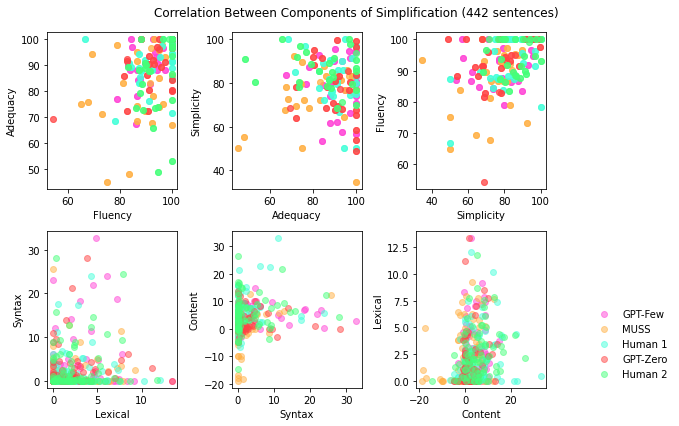

In [ ]:
conditions = [
    'quality_content', 
    'quality_syntax', 
    'quality_lexical', 
    'error_content', 
    'error_syntax', 
    'error_lexical', 
    'quality', 
    'error', 
    'all'
]

plots = [[
    ('fluency', 'adequacy'),
    ('adequacy', 'simplicity'),
    ('simplicity', 'fluency')
], [
    ('quality_lexical', 'quality_syntax'),
    ('quality_syntax', 'quality_content'),
    ('quality_content', 'quality_lexical')
]]

total_sent = 0
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
for system in systems:    
    pts = []
    for sent in [s for s in data if s['system'] == system]:
        if sent['simpeval_scores'] != None and sent['da_scores'] != None:
            # edit distance
            # scores += [(
            #     avg(sent['simpeval_scores'], prec=10), 
            #     edit_dist(sent['original'], sent['simplified'])
            # )]
            score = {}
            for condition in conditions:
                score[f'our_score_{condition}'] = calculate_sentence_score(sent, get_params(condition))
            
            pts += [[[(
                avg([x['fluency'] for x in sent['da_scores']]),
                avg([x['adequacy'] for x in sent['da_scores']]),
            ), (
                avg([x['adequacy'] for x in sent['da_scores']]),
                avg([x['simplicity'] for x in sent['da_scores']]),
            ), (
                avg([x['simplicity'] for x in sent['da_scores']]),
                avg([x['fluency'] for x in sent['da_scores']]),
            )], [(
                score[f'our_score_quality_lexical'],
                score[f'our_score_quality_syntax'],
            ), (
                score[f'our_score_quality_syntax'],
                score[f'our_score_quality_content'],
            ), (
                score[f'our_score_quality_content'],
                score[f'our_score_quality_lexical']
            )]]]
        total_sent += 1

    for i in range(2):
        for j in range(3):
            axs[i, j].scatter([p[i][j][0] for p in pts], [p[i][j][1] for p in pts], c=color_mapping[system], alpha=0.5, label=system_name_mapping[system])

axs[0, 0].set_xlabel('Fluency')
axs[0, 0].set_ylabel('Adequacy')

axs[0, 1].set_xlabel('Adequacy')
axs[0, 1].set_ylabel('Simplicity')

axs[0, 2].set_xlabel('Simplicity')
axs[0, 2].set_ylabel('Fluency')

axs[1, 0].set_xlabel('Lexical')
axs[1, 0].set_ylabel('Syntax')

axs[1, 1].set_xlabel('Syntax')
axs[1, 1].set_ylabel('Content')

axs[1, 2].set_xlabel('Content')
axs[1, 2].set_ylabel('Lexical')

plt.suptitle(f'Correlation Between Components of Simplification ({total_sent} sentences)')
# font_size = 8
# legend_loc = (0, 0)
# plt.legend(loc='lower center', bbox_to_anchor=legend_loc,
#             fancybox=True, ncol=2, borderaxespad=1.,fontsize=font_size,
#             facecolor='white',edgecolor='black',framealpha=1,frameon=False,
#             columnspacing=1,handlelength=1,handleheight=1,handletextpad=0.4,
#             borderpad=0.2)
plt.legend(loc='lower right', bbox_to_anchor=(2, 0), frameon=False)
plt.show()

In [ ]:
# Get the percentile of a score among some systems
from scipy.stats import percentileofscore
system = 'GPT-3-few'
raw_scores = [9, 6.7, 1.46]
i = 0
for dim in ['content', 'syntax', 'lexical']:
    scores = []
    for sent in [x for x in data if system in x['system']]:
        scores += [
            calculate_sentence_score(sent, get_params(f'quality_{dim}')) +
            calculate_sentence_score(sent, get_params(f'error_{dim}'))
        ]

    percentile_of_3 = percentileofscore(scores, raw_scores[i])

    i += 1
    print(percentile_of_3)

91.11111111111111
88.88888888888889
48.888888888888886


In [ ]:
raw_score = 0.617
scores = []
system = 'Human'
for sent in [x for x in data if system in x['system']]:
    simpeval_scores = sent['simpeval_scores']
    if simpeval_scores != None:
        scores += [avg(simpeval_scores)]
percentileofscore(scores, raw_score)

65.69767441860465

In [ ]:
raw_score = 96.4
scores = []
system = 'GPT-3-few'
for sent in [x for x in data if system in x['system']]:
    if sent['da_scores'] != None:
        da_scores = [avg(x.values()) for x in sent['da_scores']]
        scores += [avg(da_scores)]
percentileofscore(scores, raw_score)

93.10344827586206

### Edit Reversing

In [ ]:
# Problems with reversing edits:
    # Overlapping edits (of different types)
    # Deletions have no mapping to the original sentence
    # Re-orders have no mapping to their original location

In [ ]:
# My approach
    # use generate_token_dict(s) to get a list of token spans for the input/output
    # iterate through edits (in some predetermined priority order) to list the operations we perform on each word
    # perform those operations to collapse the sentence

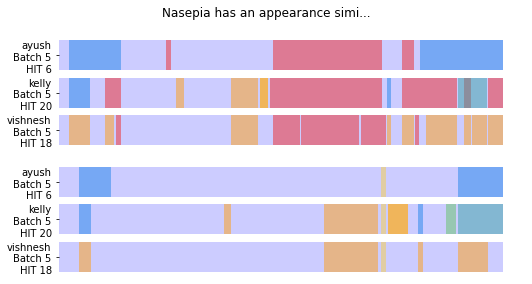

In [ ]:
from graphs import *

id_ = 40
sents = [sent for sent in data if sent['id'] == id_]
draw_agreement(sents)